In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from collections import deque
import random
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [6]:
data = pd.read_csv("doge_data.csv")
data = data.rename({'Datetime': 'Date'}, axis=1)
data = data.set_index("Date")
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-31 23:00:00+00:00,0.004672,0.004704,0.004648,0.004683,0.004683,0
2021-01-01 00:00:00+00:00,0.004681,0.004703,0.004615,0.004693,0.004693,0
2021-01-01 01:00:00+00:00,0.004693,0.004752,0.004689,0.004739,0.004739,0
2021-01-01 02:00:00+00:00,0.004738,0.004752,0.004729,0.004750,0.004750,0
2021-01-01 03:00:00+00:00,0.004750,0.004983,0.004750,0.004978,0.004978,9477800
...,...,...,...,...,...,...
2021-04-01 18:00:00+00:00,0.058733,0.059011,0.057618,0.058724,0.058724,173274112
2021-04-01 19:00:00+00:00,0.058836,0.059053,0.058329,0.058545,0.058545,75353600
2021-04-01 20:00:00+00:00,0.058543,0.060973,0.058543,0.059997,0.059997,252666880


# Q Learning Agent

In [7]:
df= data.copy()
name = 'Q-learning agent'
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [12]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.


epoch: 10, total rewards: 2.578501.3, cost: 0.000000, total money: 9996.264378
epoch: 20, total rewards: 1.218274.3, cost: 0.000000, total money: 9997.804083
epoch: 30, total rewards: 0.580812.3, cost: 0.000000, total money: 9998.370519
epoch: 40, total rewards: 0.548195.3, cost: 0.000000, total money: 9998.986761
epoch: 50, total rewards: 0.559445.3, cost: 0.000000, total money: 9999.430349
epoch: 60, total rewards: 0.504975.3, cost: 0.000000, total money: 9999.753958
epoch: 70, total rewards: 0.473946.3, cost: 0.000000, total money: 10000.152467
epoch: 80, total rewards: 0.469571.3, cost: 0.000000, total money: 10000.148093
epoch: 90, total rewards: 0.503783.3, cost: 0.000000, total money: 10000.074975
epoch: 100, total rewards: 0.468236.3, cost: 0.000000, total money: 10000.468236
epoch: 110, total rewards: 0.420372.3, cost: 0.000000, total money: 10000.420372
epoch: 120, total rewards: 0.466381.3, cost: 0.000000, total money: 10000.466381
epoch: 130, total rewards: 0.555078.3, cost

In [13]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 44: buy 1 unit at price 0.011890, total balance 9999.988110
day 47, sell 1 unit at price 0.011189, investment -5.900257 %, total balance 9999.999298,
day 50: buy 1 unit at price 0.009894, total balance 9999.989404
day 51: buy 1 unit at price 0.009951, total balance 9999.979453
day 52, sell 1 unit at price 0.010976, investment 10.928591 %, total balance 9999.990429,
day 55: buy 1 unit at price 0.012436, total balance 9999.977993
day 56, sell 1 unit at price 0.012415, investment 24.763352 %, total balance 9999.990408,
day 58: buy 1 unit at price 0.011736, total balance 9999.978672
day 59: buy 1 unit at price 0.011737, total balance 9999.966934
day 60, sell 1 unit at price 0.013081, investment 5.187448 %, total balance 9999.980015,
day 61, sell 1 unit at price 0.013033, investment 11.045047 %, total balance 9999.993048,
day 62, sell 1 unit at price 0.012760, investment 8.709938 %, total balance 10000.005808,
day 71: buy 1 unit at price 0.010093, total balance 9999.995715
day 73, sell 

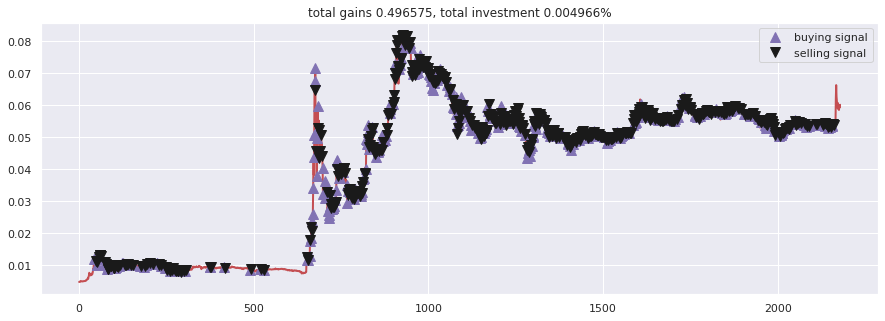

In [14]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()